In [22]:
#IMPORTS put all here
import random
import matplotlib.pyplot as plt

#tf imports for reading file
import numpy as np
import os
import PIL

import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


#extras
print(tf.__version__)
import pathlib
import shutil
import datetime

2.9.1


In [23]:
#path to image dataset
spec_path = os.path.join(os.curdir,'spectrograms6sec')

genre_list=os.listdir(spec_path)
genre_list


['bhojpuri_pop',
 'carnatic',
 'classic_bollywood',
 'desi_pop',
 'ghazal',
 'hindustani_classical',
 'indian_indie',
 'punjabi_hip_hop',
 'sufi',
 'tamil_pop']

In [24]:
#resets the experiment
%rm -rf content/spectrograms6secnew

UsageError: Line magic function `%rm` not found.


In [25]:
# os.mkdir(os.path.join(os.curdir,'spectrograms6secnew'))
dest_path='spectrograms6secnew'

#for genre in genre_list:
#  os.mkdir(f'spectrograms6secnew/{genre}')

In [26]:


#no of samples per class
n=3000
cnt=0

random.seed(123)

for genre in genre_list:
  genre_path=os.path.join(spec_path,genre)
  dest_genre_path=os.path.join(dest_path,genre)

  #shuffling and selecting 3000 samples
  genre_songs=os.listdir(genre_path)
  random.shuffle(genre_songs)
  selected_spec=genre_songs[:n]
  
  for song in selected_spec:
      source=os.path.join(genre_path,song)
      dest=os.path.join(dest_genre_path,song)
      d= shutil.copyfile(source, dest)




In [27]:
data_dir=pathlib.Path(dest_path)
data_dir

WindowsPath('spectrograms6secnew')

In [28]:
#adding dataset
batch_size=64
image_height=75
image_width=150


In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 30000 files belonging to 10 classes.
Using 6000 files for validation.


['bhojpuri_pop', 'carnatic', 'classic_bollywood', 'desi_pop', 'ghazal', 'hindustani_classical', 'indian_indie', 'punjabi_hip_hop', 'sufi', 'tamil_pop']


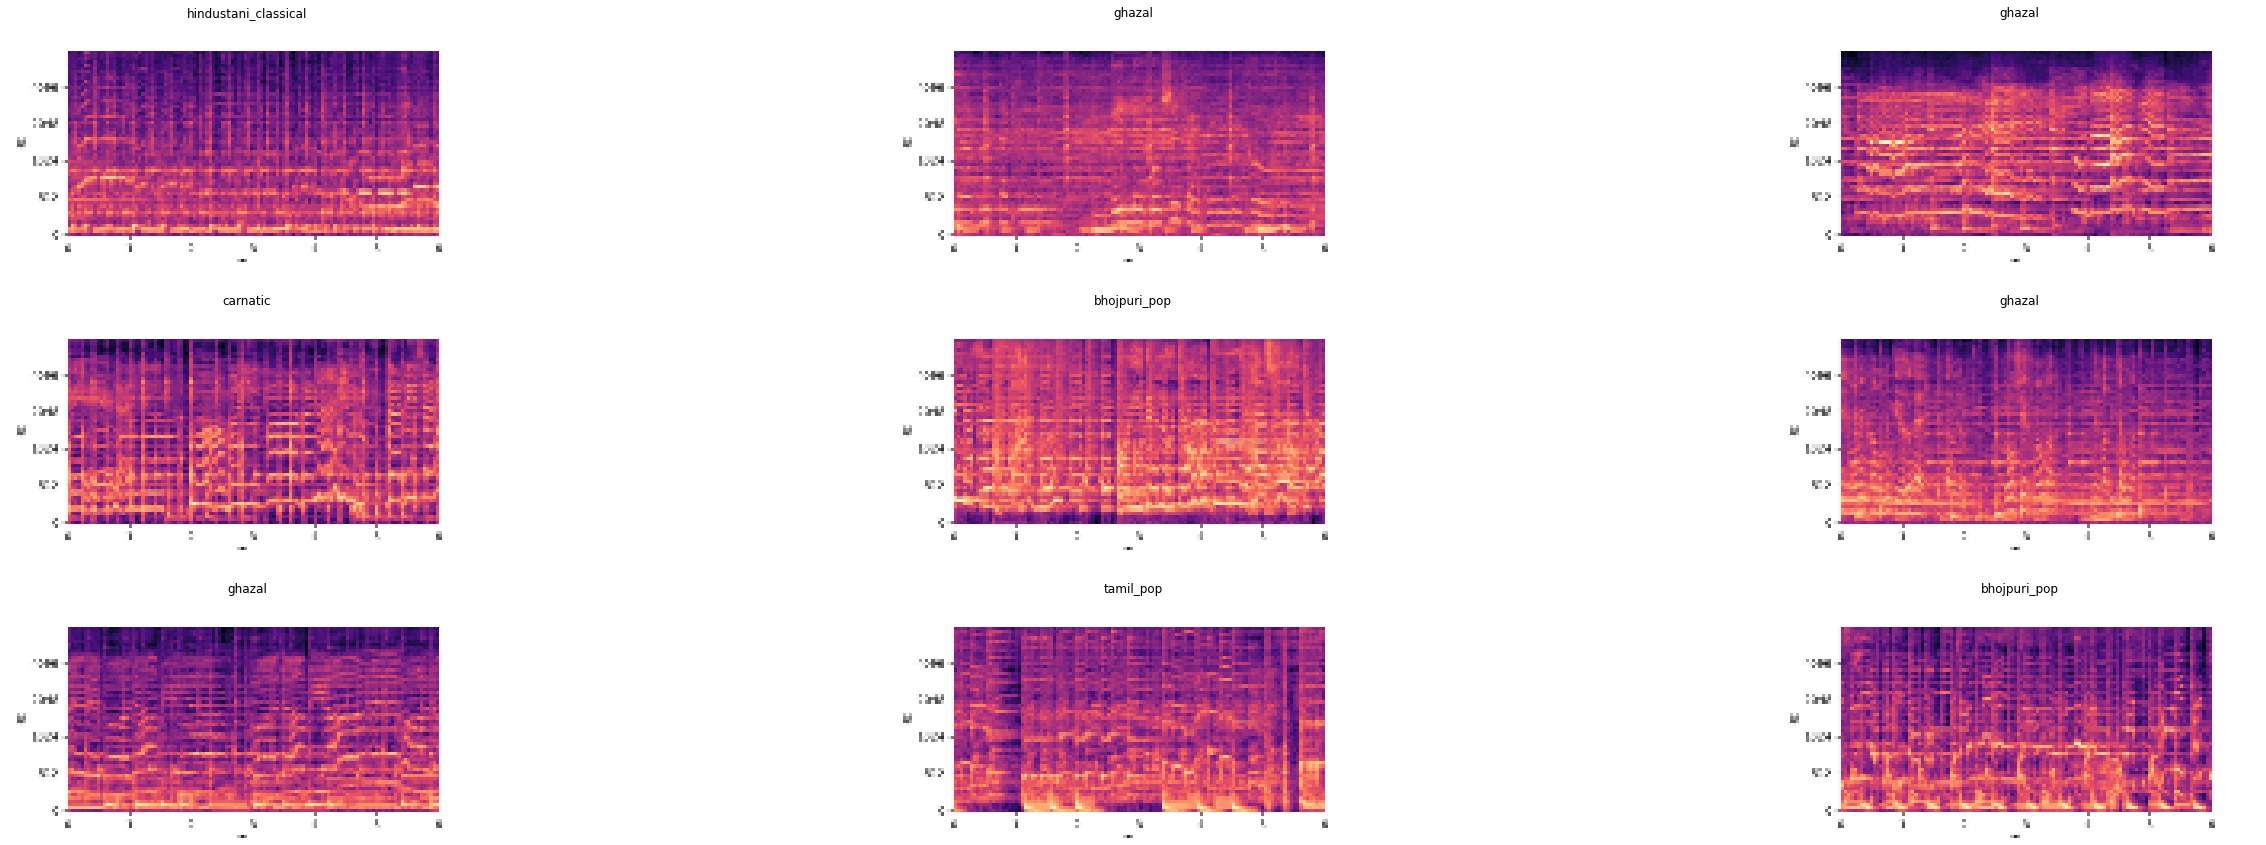

In [31]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(45, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 75, 150, 3)
(64,)


In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
#model = Sequential(
#    tf.keras.layers.Rescaling(1./255),
#)

In [36]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 4, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [37]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])

Epoch 1/10
375/375 [==============================] - 60s 157ms/step - loss: 1.8904 - accuracy: 0.3951 - val_loss: 2.9420 - val_accuracy: 0.1633
Epoch 2/10
375/375 [==============================] - 26s 69ms/step - loss: 1.4107 - accuracy: 0.5121 - val_loss: 1.4193 - val_accuracy: 0.5213
Epoch 3/10
375/375 [==============================] - 25s 66ms/step - loss: 1.2829 - accuracy: 0.5556 - val_loss: 2.1181 - val_accuracy: 0.3942
Epoch 4/10
375/375 [==============================] - 25s 66ms/step - loss: 1.2140 - accuracy: 0.5806 - val_loss: 1.7939 - val_accuracy: 0.4045
Epoch 5/10
375/375 [==============================] - 25s 66ms/step - loss: 1.1677 - accuracy: 0.5939 - val_loss: 2.4524 - val_accuracy: 0.2985
Epoch 6/10
375/375 [==============================] - 27s 72ms/step - loss: 1.1179 - accuracy: 0.6104 - val_loss: 2.1056 - val_accuracy: 0.3647
Epoch 7/10
375/375 [==============================] - 26s 70ms/step - loss: 1.0860 - accuracy: 0.6233 - val_loss: 1.6666 - val_accuracy

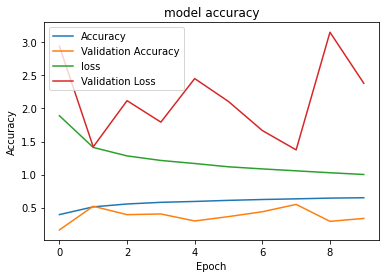

In [39]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


hyperparameter tuning 

In [40]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 4, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 4, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3,  padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [41]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])


Epoch 1/10
375/375 [==============================] - 36s 94ms/step - loss: 1.7969 - accuracy: 0.4070 - val_loss: 3.3612 - val_accuracy: 0.1730
Epoch 2/10
375/375 [==============================] - 34s 91ms/step - loss: 1.3475 - accuracy: 0.5357 - val_loss: 2.4248 - val_accuracy: 0.3043
Epoch 3/10
375/375 [==============================] - 33s 89ms/step - loss: 1.2052 - accuracy: 0.5830 - val_loss: 3.5522 - val_accuracy: 0.2118
Epoch 4/10
375/375 [==============================] - 34s 89ms/step - loss: 1.1133 - accuracy: 0.6143 - val_loss: 2.2256 - val_accuracy: 0.3560
Epoch 5/10
375/375 [==============================] - 34s 92ms/step - loss: 1.0524 - accuracy: 0.6377 - val_loss: 2.0744 - val_accuracy: 0.3658
Epoch 6/10
375/375 [==============================] - 36s 96ms/step - loss: 0.9917 - accuracy: 0.6591 - val_loss: 1.5543 - val_accuracy: 0.4808
Epoch 7/10
375/375 [==============================] - 37s 100ms/step - loss: 0.9483 - accuracy: 0.6737 - val_loss: 1.6793 - val_accuracy

In [42]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 4, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 4, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3,  padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

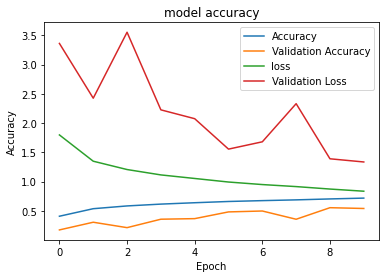

In [43]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [44]:
num_classes = 10
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Input(shape=(75, 150, 3)))
model.add(tf.keras.layers.Conv2D(16, 4, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(16, 3,  padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile('adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [45]:
logdir='logs'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist=model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[tensorboard_callback,early])


Epoch 1/10
375/375 [==============================] - 28s 72ms/step - loss: 2.0025 - accuracy: 0.3731 - val_loss: 4.1557 - val_accuracy: 0.1412
Epoch 2/10
375/375 [==============================] - 26s 69ms/step - loss: 1.4532 - accuracy: 0.5034 - val_loss: 1.6793 - val_accuracy: 0.4345
Epoch 3/10
375/375 [==============================] - 24s 65ms/step - loss: 1.2942 - accuracy: 0.5551 - val_loss: 1.7568 - val_accuracy: 0.4150
Epoch 4/10
375/375 [==============================] - 24s 64ms/step - loss: 1.2226 - accuracy: 0.5755 - val_loss: 1.3601 - val_accuracy: 0.5292
Epoch 5/10
375/375 [==============================] - 24s 65ms/step - loss: 1.1637 - accuracy: 0.5954 - val_loss: 1.4387 - val_accuracy: 0.5030
Epoch 6/10
375/375 [==============================] - 25s 67ms/step - loss: 1.1106 - accuracy: 0.6130 - val_loss: 2.0960 - val_accuracy: 0.3917
Epoch 7/10
375/375 [==============================] - 25s 67ms/step - loss: 1.0712 - accuracy: 0.6228 - val_loss: 1.9600 - val_accuracy: